# **Setup**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installat

Saving kaggle.json to kaggle.json
/bin/bash: line 1: /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json: No such file or directory
 93% 264M/285M [00:00<00:00, 466MB/s]
100% 285M/285M [00:00<00:00, 496MB/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tekla-tsutskha (tekla-tsutskha-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv
wandb
Dataset Shape:
Training set: (28709, 2)
Test set: (7178, 1)
Columns: ['emotion', 'pixels']
Emotion distribution:
emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64
Dataset shape: (7178, 1)
Columns: ['pixels']


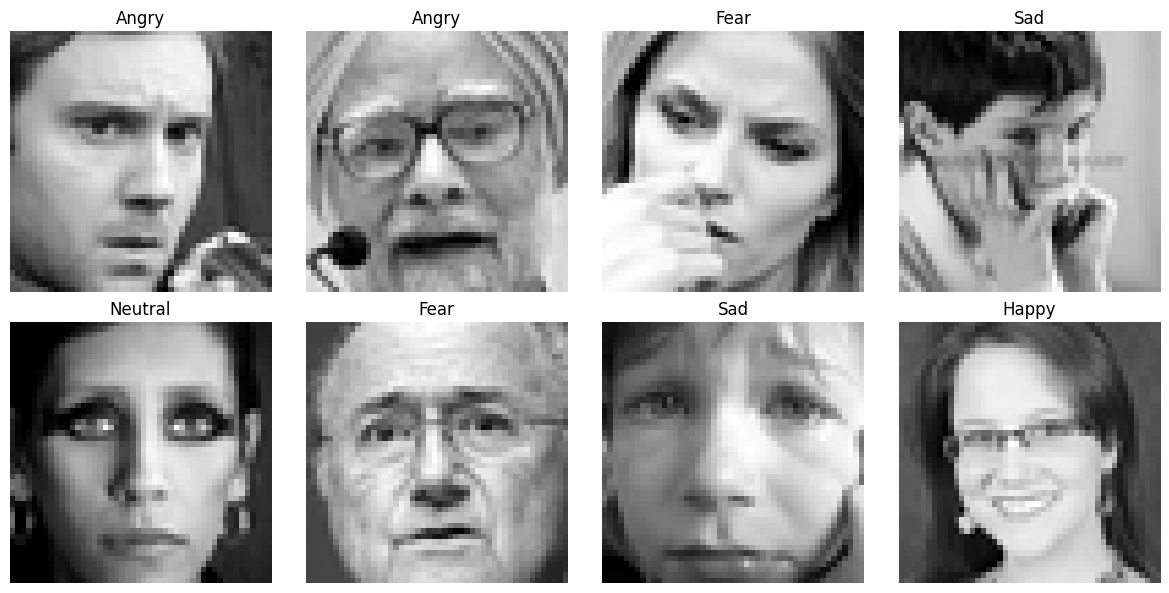

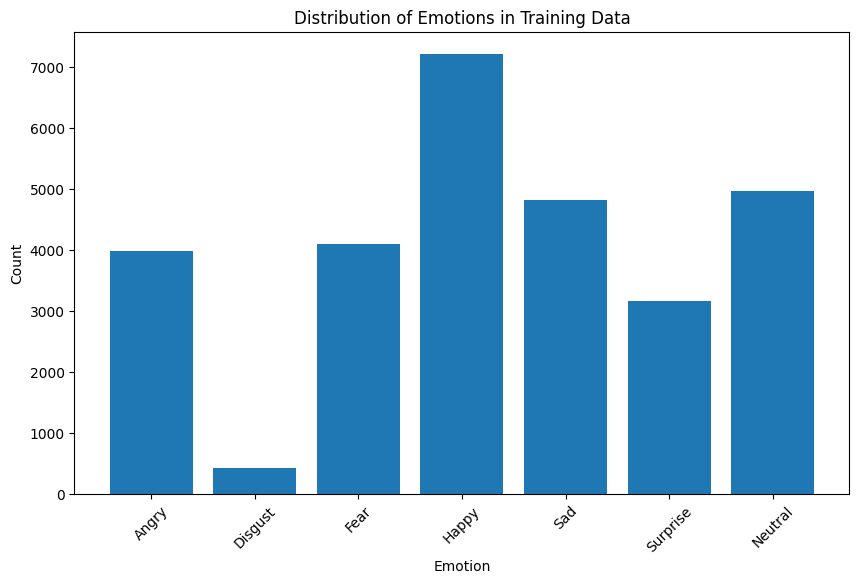

Data exploration complete!
Key observations:
- 48x48 grayscale images
- 7 emotion classes
- Check for class imbalance
- Images are relatively low resolution
Setup complete! Ready for experiments.


In [3]:
%run  "/content/drive/MyDrive/Colab Notebooks/01_data_exploration_and_setup.ipynb"


# **ResNet**

In [11]:
from torchvision.models import resnet18

class CustomResNet(nn.Module):
    def __init__(self, num_classes=7, pretrained=False):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


# **Training**

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=15, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize wandb
    wandb.init(
        project="facial-expression-recognition",
        name="experiment_2_resnet18",
        config={
            "model": "ResNet18",
            "epochs": num_epochs,
            "learning_rate": lr,
            "batch_size": train_loader.batch_size,
            "optimizer": "Adam",
            "pretrained": False
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        train_loss /= len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Log to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    wandb.finish()
    return train_losses, val_losses, train_accs, val_accs


# **Run experiment**

In [12]:
model = CustomResNet(pretrained=False)
train_loader, val_loader = create_basic_loaders(batch_size=64)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Starting training...")

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model parameters: 11,173,831
Starting training...


Epoch 0: Train Loss: 1.5381, Train Acc: 40.04%, Val Loss: 1.3862, Val Acc: 46.33%
Epoch 5: Train Loss: 0.7493, Train Acc: 72.76%, Val Loss: 1.3696, Val Acc: 52.32%
Epoch 10: Train Loss: 0.2025, Train Acc: 93.04%, Val Loss: 1.9518, Val Acc: 55.38%


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▁▂▃▄▄▅▆▆▇▇█████
train_loss,█▇▆▆▅▄▃▃▂▂▁▁▁▁▁
val_accuracy,▁▃▇▆█▅▇▇▇▆▇▇▇▇▇
val_loss,▂▂▁▁▁▂▂▃▄▅▆▆▆▆█
epoch,14
train_accuracy,96.28598
train_loss,0.11088
val_accuracy,56.65273
val_loss,2.32652


# **Result Analyze**

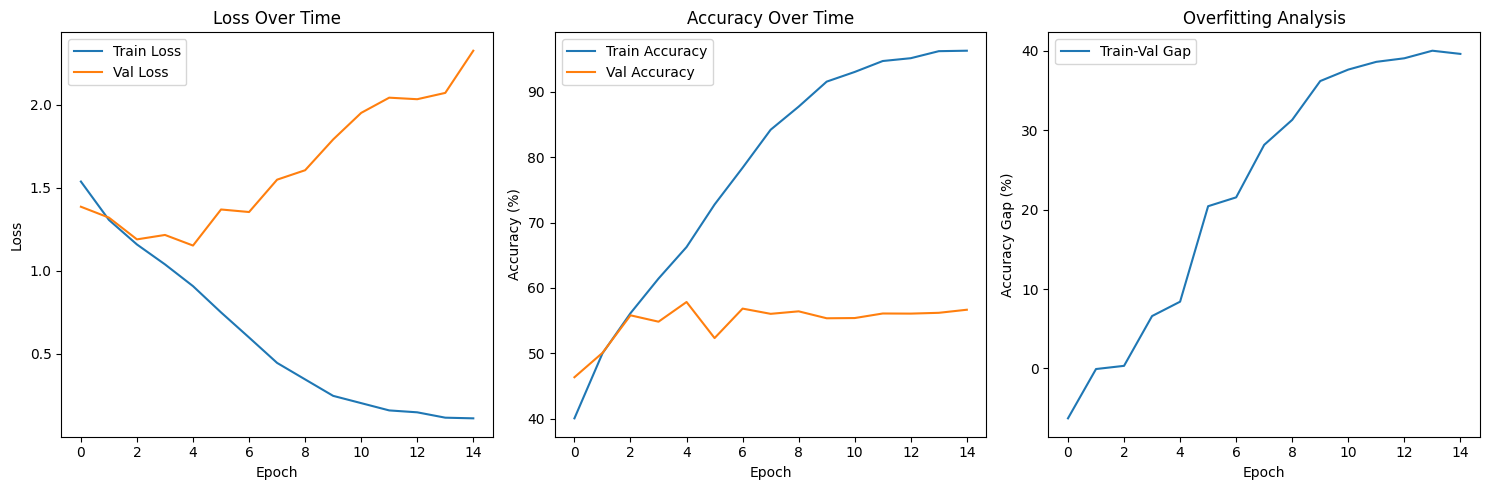

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(train_accs) - np.array(val_accs), label='Train-Val Gap')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (%)')
plt.title('Overfitting Analysis')
plt.legend()

plt.tight_layout()
plt.show()
